In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import string
import nltk
from nltk.corpus import stopwords
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [20]:
###!fusermount -u drive

In [2]:
from google.colab import drive


In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
##train = '/content/drive/My Drive/Colab Notebooks/genuine/nlp_twitter/nlp-getting-started/train.csv'
##test = '/content/drive/My Drive/Colab Notebooks/genuine/nlp_twitter/nlp-getting-started/test.csv'

In [14]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/genuine/nlp_twitter/nlp-getting-started/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/genuine/nlp_twitter/nlp-getting-started/test.csv')

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


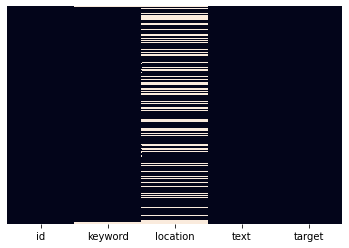

In [15]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,linecolor = 'yellow' )

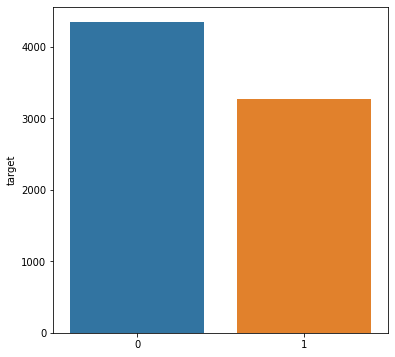

In [16]:
plt.figure(figsize=(6,6))
sns.barplot(train.target.value_counts().index,train.target.value_counts())

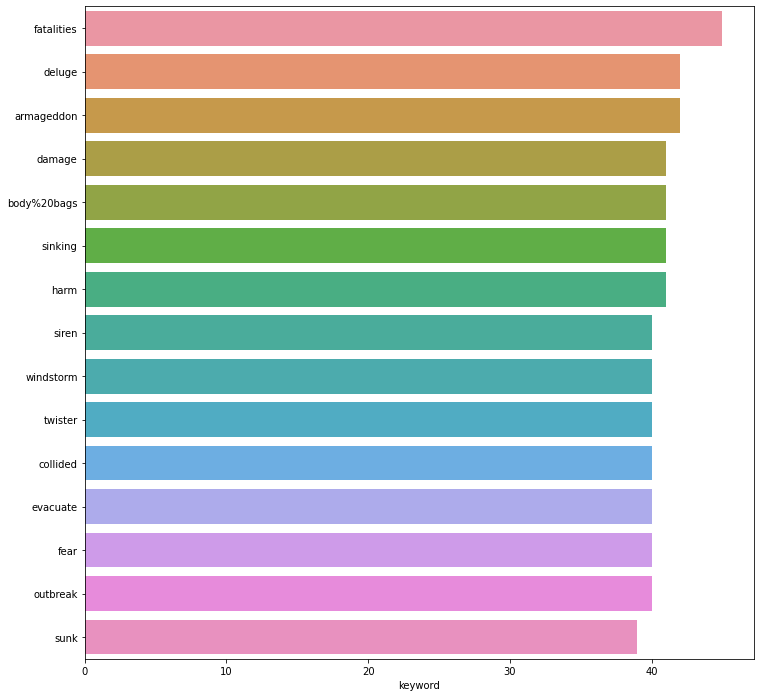

In [ ]:
plt.figure(figsize=(12,12))
sns.barplot(y=train.keyword.value_counts().index[:15],x=train.keyword.value_counts()[:15])

In [ ]:
train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

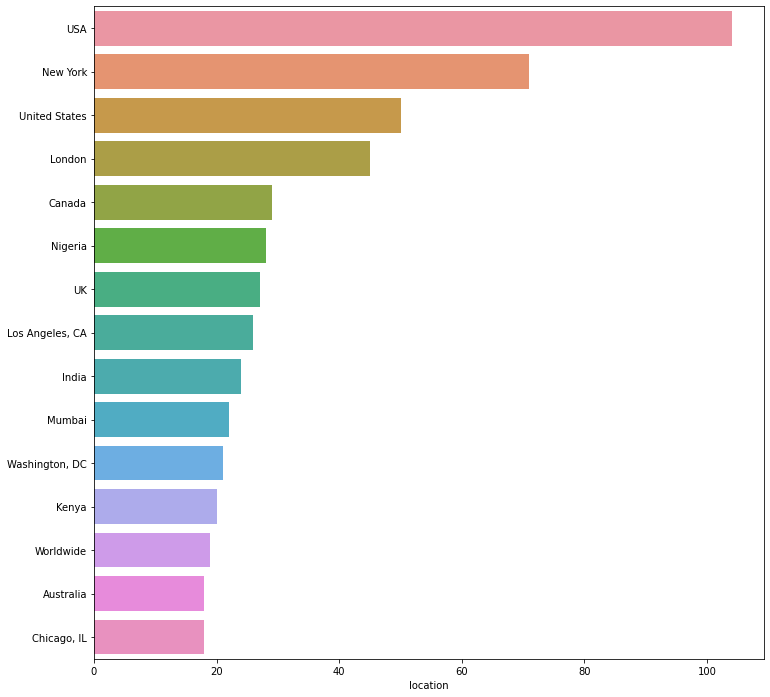

In [ ]:
plt.figure(figsize=(12,12))
sns.barplot(y=train.location.value_counts().index[:15],x=train.location.value_counts()[:15])

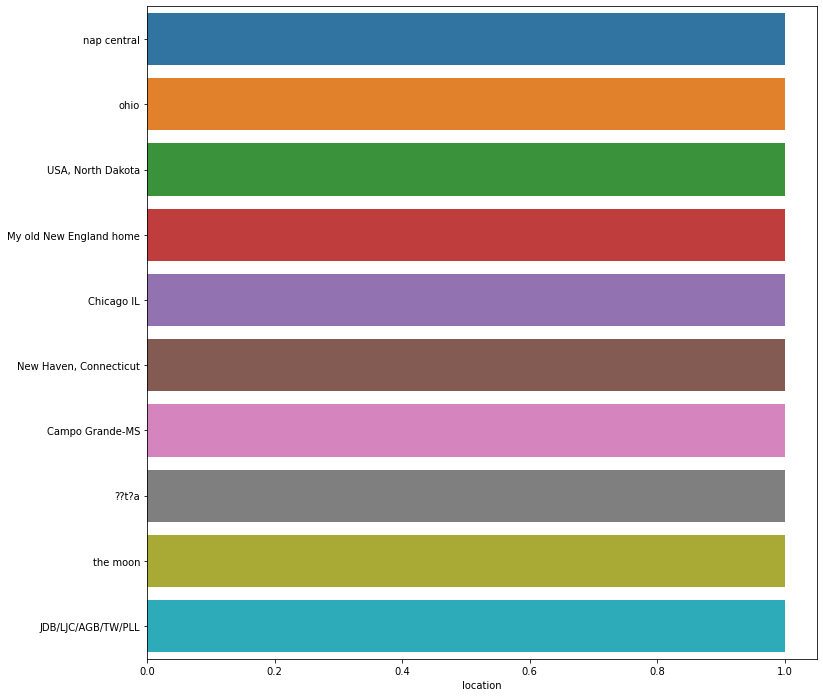

In [ ]:
plt.figure(figsize=(12,12))
sns.barplot(y=train.location.value_counts().index[-10:],x=train.location.value_counts()[-10:])

In [18]:
def lowercase_text(text):
  return text.lower()



train.text =  train.text.apply(lambda x: lowercase_text(x))
test.text = test.text.apply(lambda x: lowercase_text(x))

In [19]:
train.text.head(7)

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
5    #rockyfire update => california hwy. 20 closed...
6    #flood #disaster heavy rain causes flash flood...
Name: text, dtype: object

In [20]:
def remove_noise(text):
  text = re.sub('\[.*?\]','',text)
  text = re.sub('https://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text
                

In [21]:
train.text=train.text.apply(lambda x: remove_noise(x))
test.text=test.text.apply(lambda x: remove_noise(x))

In [22]:
train.text.head(7)

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
5    rockyfire update  california hwy  closed in bo...
6    flood disaster heavy rain causes flash floodin...
Name: text, dtype: object

In [23]:
!pip install nlppreprocess
from nlppreprocess import NLP


nlp = NLP()
train['text'] = train['text'].apply(nlp.process)
test['text'] = test['text'].apply(nlp.process)

In [24]:
train.text.sample(10)

5276    refugio oil spill may been costlier bigger tha...
1825    could anyone tell crashed just taking very lon...
5204                 cant wait beyond obliterated weekend
1201    minimehh cjoyner must overlooking burning buil...
4005    apc chieftain tasks dickson floods donation ba...
1893                          wow crushed edwing bluejays
6290    my last two weather pics from storm august peo...
7097    stormchase violent record breaking el reno okl...
364                      beyonce my pick fan army beyhive
6962                     man my stomach feel like tsunami
Name: text, dtype: object

In [25]:
stemmer = SnowballStemmer('english')


def stemming(text):
  text = [stemmer.stem(word) for word in text.split()]
  return ' '.join(text)

train['text'] = train['text'].apply(stemming)
test['text'] = test['text'].apply(stemming)

Text(0.5, 1.0, 'Frequent Words')

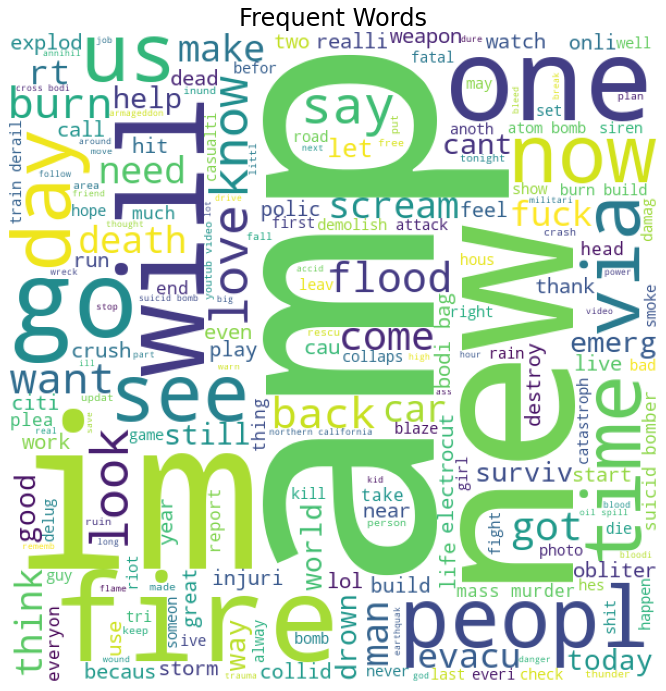

In [26]:
from wordcloud import WordCloud
fig , ax1 = plt.subplots(1,figsize=(12,12))
wordcloud=WordCloud(background_color='white',width=600,height=600).generate(" ".join(train.text))
ax1.imshow(wordcloud)
ax1.axis('off')
ax1.set_title('Frequent Words',fontsize=24)

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer=CountVectorizer(analyzer='word',binary=True)
count_vectorizer.fit(train.text)

train_vec = count_vectorizer.fit_transform(train.text)
test_vec = count_vectorizer.transform(test.text)

print(train_vec[7].todense())
print(test_vec[7].todense())

[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]


In [32]:
y=train.target

In [33]:
from sklearn import model_selection
model =MultinomialNB(alpha=1)
scores= model_selection.cross_val_score(model,train_vec,y,cv=6,scoring='f1')
scores

array([0.67716535, 0.63525305, 0.65953947, 0.62209842, 0.72067511,
       0.72961373])

In [34]:
model.fit(train_vec,y)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [35]:
sample_submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/genuine/nlp_twitter/nlp-getting-started/sample_submission.csv')

In [36]:
sample_submission.target= model.predict(test_vec)

In [37]:
sample_submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [38]:
sample_submission.to_csv('submission.csv',index=False)